<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_no_wordfeatures_trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will first get a baseline for how far we are able to get with features not including anything about the words. 



1. Trial 1: just the delta, history correct, history seen, p_forgot_bin, ui language dummies, and learning language dummies. - this notebook. 

The dataset (training+val) would have ~7 mill records, with 11 variables. Target variable is p_forgot_bin. 

We have the rest still available to act as test set (6 mill records)

Split 80-20 training and validation. 
We will first cross validate 10 fold, and then test on our 'validation set'. (Test set is after adding word features, here we are getting baselines, so we know how much the word features help.)

We will try both the std scaler, and the min max scaler. 

We will try the following models:

1. logistic regression L2, with different class weights and regularization strength parameter hyperparameter tuning. (since it is a very imbalanced dataset).
3. decision tree with hyperparameters max_depth, class_weight, random_state should be fixed in case of ties. 
4. SVM with different solvers (linear and radial) - try downsampling, mostly down and a little up and so on. 
5. kNN with different k, keeping reasonable run times. - different metrics
6. Random forest clasifier, play with random states, also cross-validate
7. VotingClassifier - with perhaps the better performing classic models.



In [3]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


In [4]:
q1df1 = decompress_pickle(path_name+"q1_fulldataset_wordsonly.pbz2")

In [5]:
q1df1.head()

,delta,history_seen,history_correct,p_forgot_bin,LL__en,LL__es,LL__fr,LL__it,LL__pt,UIL__en,UIL__es,UIL__pt
7,444407,3,3,0,0,1,0,0,0,1,0,0
15,77,5,5,0,0,1,0,0,0,1,0,0
20,1634777,9,8,0,0,1,0,0,0,1,0,0
21,1708699,7,5,0,0,1,0,0,0,1,0,0
22,1708699,8,8,0,0,1,0,0,0,1,0,0


Checking the target variable value proportions:

In [6]:
q1df1['p_forgot_bin'].value_counts(normalize=True)

0    0.838854
1    0.161146
Name: p_forgot_bin, dtype: float64

Only 16% of the dataset are 0.16.

Splitting the dataset. 80-20 ratio. 

We will upsample/downsample adjust class weights based on the models.

In [7]:
from sklearn.model_selection import train_test_split

X = q1df1.drop('p_forgot_bin',axis=1)
y = q1df1['p_forgot_bin']

X_train_unscaled,X_test_unscaled,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify = q1df1['p_forgot_bin'],random_state=1)

In [8]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(0    0.838854
 1    0.161146
 Name: p_forgot_bin, dtype: float64, 0    0.838854
 1    0.161146
 Name: p_forgot_bin, dtype: float64)

The datasets are stratified so the porportions are about the same. 

### 1. Logistic Regression with L2 regulatization



In [9]:
from sklearn.preprocessing import MinMaxScaler # Import the scaler

# importing metrics
from sklearn.metrics import accuracy_score,\
 roc_auc_score, plot_roc_curve,f1_score,\
  confusion_matrix, classification_report,\
  precision_recall_curve


# 1. make a scaler
minmax_scaler = MinMaxScaler()

# 2. fit the scaler to training set
minmax_scaler.fit(X_train_unscaled)

# 3. transforming training and testing sets based on scaler
X_mm_train = minmax_scaler.transform(X_train_unscaled)
X_mm_test = minmax_scaler.transform(X_test_unscaled)



In [10]:
from sklearn.linear_model import LogisticRegression
logreg1 = LogisticRegression(solver = 'lbfgs',max_iter=1000,penalty='l2',class_weight = {0:0.01,1:0.99},C=10,verbose=10)

logreg1.fit(X_mm_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.6s finished


LogisticRegression(C=10, class_weight={0: 0.01, 1: 0.99}, max_iter=1000,
                   verbose=10)

In [17]:
y_predicted = logreg1.predict(X_mm_test)

print(classification_report(y_test,y_predicted))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00   1226968
           1       0.16      1.00      0.28    235703

    accuracy                           0.16   1462671
   macro avg       0.08      0.50      0.14   1462671
weighted avg       0.03      0.16      0.04   1462671



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision is not great. It is unlikely that logistic regression with no additional will give us predictive ability. 

We will try one pass with tuning class weight and regularization strength. 

Pass1: class weights = {0:0.5, 1:0.5}, {0:0.3, 1:0.7}, {0:0.05,1:0.95}, C = .0001, 1, 100

In [18]:
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV

classweight_vals = [{0:0.5, 1:0.5}, {0:0.3, 1:0.7}, {0:0.05,1:0.95}]
C_vals = [.0001, 1, 100]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['C'] = C_vals


# iterate over 
logreg1 = LogisticRegression(solver = 'lbfgs',max_iter=1000,penalty='l2')
scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(logreg1, param_grid = para_dict,cv=4,scoring = scoring_metrics, verbose=15,refit=False,return_train_score=True)

gridsearch_obj.fit(X_mm_train,y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START C=0.0001, class_weight={0: 0.5, 1: 0.5}.....................
[CV 1/4; 1/9] END C=0.0001, class_weight={0: 0.5, 1: 0.5}; accuracy: (train=0.839, test=0.839) average_precision: (train=0.179, test=0.179) f1: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.533, test=0.534) total time=  13.6s
[CV 2/4; 1/9] START C=0.0001, class_weight={0: 0.5, 1: 0.5}.....................
[CV 2/4; 1/9] END C=0.0001, class_weight={0: 0.5, 1: 0.5}; accuracy: (train=0.839, test=0.839) average_precision: (train=0.179, test=0.179) f1: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.534, test=0.533) total time=  13.2s
[CV 3/4; 1/9] START C=0.0001, class_weight={0: 0.5, 1: 0.5}.....................
[CV 3/4; 1/9] END C=0.0001, class_weight={0: 0.5, 1: 0.5}; accuracy: (train=0.839, test=0.839) average_precision: (train=0.179, test=0.179) f1: (train=0.000, test=0.000) recall: (tr

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.0001, 1, 100],
                         'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.3, 1: 0.7},
                                          {0: 0.05, 1: 0.95}]},
             refit=False, return_train_score=True,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=15)

Pass 2: higher C value: 10^4, 10^6. keep class weight skewed to 1. 

In [22]:

C_vals = [10000, 10**6]

para_dict =dict()
para_dict['C'] = C_vals


# iterate over 
logreg2 = LogisticRegression(solver = 'lbfgs',max_iter=1000,penalty='l2',class_weight = {0:0.01,1:0.99})
scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(logreg2, param_grid = para_dict,cv=2,scoring = scoring_metrics, verbose=15,refit=False,return_train_score=True)

gridsearch_obj.fit(X_mm_train,y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2; 1/2] START C=10000.....................................................
[CV 1/2; 1/2] END C=10000; accuracy: (train=0.161, test=0.161) average_precision: (train=0.207, test=0.208) f1: (train=0.278, test=0.278) recall: (train=1.000, test=1.000) roc_auc: (train=0.574, test=0.574) total time=  26.4s
[CV 2/2; 1/2] START C=10000.....................................................
[CV 2/2; 1/2] END C=10000; accuracy: (train=0.161, test=0.161) average_precision: (train=0.207, test=0.206) f1: (train=0.278, test=0.278) recall: (train=1.000, test=1.000) roc_auc: (train=0.573, test=0.573) total time=  32.9s
[CV 1/2; 2/2] START C=1000000...................................................
[CV 1/2; 2/2] END C=1000000; accuracy: (train=0.161, test=0.161) average_precision: (train=0.207, test=0.208) f1: (train=0.278, test=0.278) recall: (train=1.000, test=1.000) roc_auc: (train=0.574, test=0.575) total time=  27.9s
[CV 2/2; 2/2] STAR

GridSearchCV(cv=2,
             estimator=LogisticRegression(class_weight={0: 0.01, 1: 0.99},
                                          max_iter=1000),
             param_grid={'C': [10000, 1000000]}, refit=False,
             return_train_score=True,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=15)

Precision is maxed out at around 0.21, recall is 1.0. 
This can be considered the best performance for logistic regression. We can plot out the accuracy vs threshold curve, and look at the strength of coefficients. 

In [23]:
logregbest = LogisticRegression(solver = 'lbfgs',max_iter=1000,penalty='l2',class_weight = {0:0.01,1:0.99},C=10000)
logregbest.fit(X_mm_train,y_train)
y_proba = logregbest.predict_proba(X_mm_test)

In [29]:
threshold_range = range(0,10,1)
acc_dict = dict()
y_1_pred = y_proba[:,1]

for threshold in threshold_range:
  acc_dict[threshold/10] = accuracy_score(y_test,np.where(y_1_pred>threshold/10,1,0))

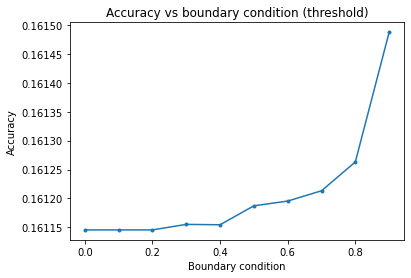

In [31]:
acc_threshold = pd.Series(acc_dict)
plt.figure()
plt.title("Accuracy vs boundary condition (threshold)")
plt.xlabel("Boundary condition")
plt.ylabel("Accuracy")
plt.plot(acc_threshold,'.-')
plt.show()

Accuracy doesn't change much across the boundary condition.

Looking at coefficient values:

In [34]:
coefs = logregbest.coef_[0].tolist()
cols = [col for col in X_train_unscaled.columns]
coef_dict = dict(zip(cols,coefs))
coefficients = pd.Series(coef_dict)

coefficients.abs().sort_values(ascending=False)

history_correct    351.315906
history_seen       347.520719
delta                1.394040
UIL__en              0.917662
LL__en               0.763926
LL__fr               0.433847
UIL__es              0.392760
UIL__pt              0.371167
LL__es               0.241267
LL__it               0.139074
LL__pt               0.103473
dtype: float64

As might be expected history correct and history seen are definitely the most important coefficients in the model. delta is next. 

Now we will see if decision trees will do better. 

In [61]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


dtree = DecisionTreeClassifier(max_depth = 6,class_weight={0:.05,1:0.95})

dtree.fit(X_train_unscaled,y_train)

y_test_predicted = dtree.predict(X_test_unscaled)
y_train_predicted = dtree.predict(X_train_unscaled)
# calculate accuracy
test_acc = accuracy_score(y_test, y_test_predicted)
train_acc = accuracy_score(y_train,y_train_predicted)

print(f"Test accuracy is : {test_acc}")
print(f"Train accuracy is : {train_acc}")


Test accuracy is : 0.1611791031612714
Train accuracy is : 0.16117468678443184


An accuracy of 0.16 is equivalent to the logistic regression scores. Roughly 20s to train.

Hyperparameter tuning: 

Pass 1 - class weights for 1-0.5 to 0.95, and max_depth 5-25

In [63]:
max_depths = [5,10,15,20,25]
class_weights = [{0:0.5,1:0.5},{0:0.3,1:0.7},{0:0.05,1:0.95}]

para_dict =dict()
para_dict['max_depth'] = max_depths
para_dict['class_weight'] = class_weights


# iterate over 
dtree1 = DecisionTreeClassifier(random_state=1)
scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(dtree1, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=15,refit=False,return_train_score=True)

gridsearch_obj.fit(X_train_unscaled,y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3; 1/15] START class_weight={0: 0.5, 1: 0.5}, max_depth=5.................
[CV 1/3; 1/15] END class_weight={0: 0.5, 1: 0.5}, max_depth=5; accuracy: (train=0.839, test=0.839) average_precision: (train=0.194, test=0.194) f1: (train=0.003, test=0.003) recall: (train=0.001, test=0.001) roc_auc: (train=0.559, test=0.559) total time=  14.3s
[CV 2/3; 1/15] START class_weight={0: 0.5, 1: 0.5}, max_depth=5.................
[CV 2/3; 1/15] END class_weight={0: 0.5, 1: 0.5}, max_depth=5; accuracy: (train=0.839, test=0.839) average_precision: (train=0.194, test=0.193) f1: (train=0.002, test=0.003) recall: (train=0.001, test=0.001) roc_auc: (train=0.559, test=0.558) total time=  14.3s
[CV 3/3; 1/15] START class_weight={0: 0.5, 1: 0.5}, max_depth=5.................
[CV 3/3; 1/15] END class_weight={0: 0.5, 1: 0.5}, max_depth=5; accuracy: (train=0.839, test=0.839) average_precision: (train=0.194, test=0.194) f1: (train=0.003, test=0.003

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.3, 1: 0.7},
                                          {0: 0.05, 1: 0.95}],
                         'max_depth': [5, 10, 15, 20, 25]},
             refit=False, return_train_score=True,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=15)

Performance is barely better than logistic regression, and it overfits very quickly. 

Best model is max_depth=15, class weights 1= 0.95

In [66]:
dtreebest = DecisionTreeClassifier(max_depth = 15,class_weight={0:.0001,1:0.9999})
dtreebest.fit(X_train_unscaled,y_train)
y_pred = dtreebest.predict(X_test_unscaled)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.00      0.00   1226968
           1       0.16      1.00      0.28    235703

    accuracy                           0.16   1462671
   macro avg       0.51      0.50      0.14   1462671
weighted avg       0.74      0.16      0.05   1462671



Using max depth = 20


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 30


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 40


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 50


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Using max depth = 60


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


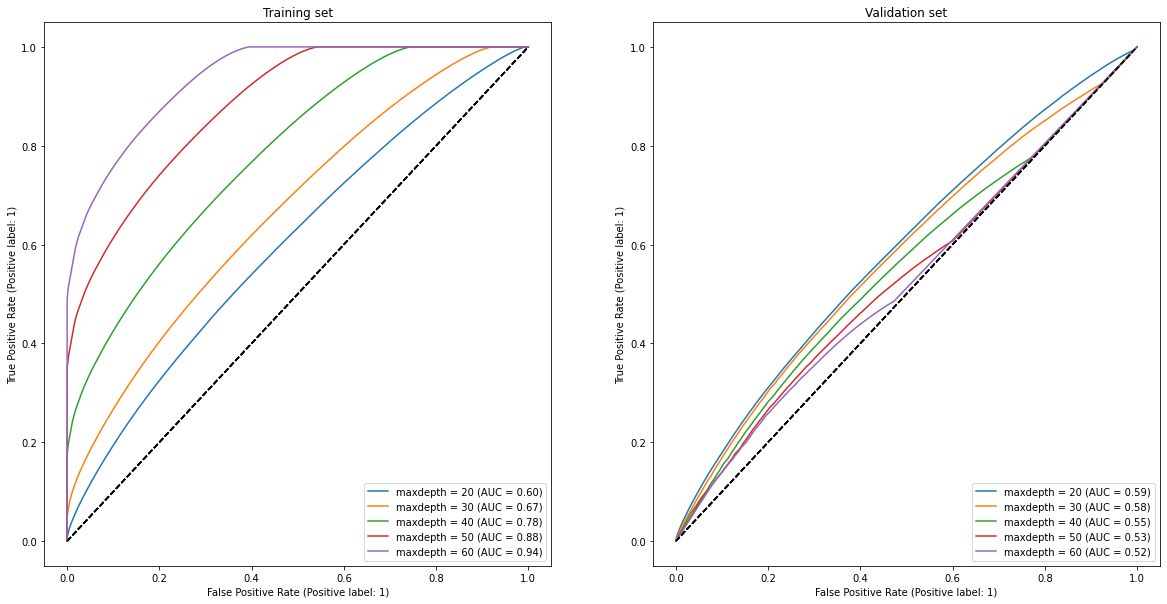

In [72]:

# creating dictionaries to store metrics for different knn models
valid_acc = dict()
train_acc = dict()

valid_AUC = dict()
train_AUC = dict()

train_cm = dict()
valid_cm = dict()

train_f1 = dict()
valid_f1 = dict()

train_prc = dict()
valid_prc = dict()

train_proba1 = dict()
valid_proba1 = dict()


# create subplots
figs, axes = plt.subplots(1, 2, figsize=(20, 10))


depths = range(20,61,10)

for d in depths:
  print(f"Using max depth = {d}")
  DTCmodel = DecisionTreeClassifier(max_depth = d,class_weight={0:.0001,1:0.9999}) # intitalize a DTCmodel with a new max depth
  DTCmodel.fit(X_train_unscaled,y_train) # fit the model to unscaled train data

  # predicting on training and validation sets
  y_train_predicted = DTCmodel.predict(X_train_unscaled) 
  y_test_predicted = DTCmodel.predict(X_test_unscaled) 

  # soft predictions on training and validation data
  y_train_proba = DTCmodel.predict_proba(X_train_unscaled) 
  y_test_proba = DTCmodel.predict_proba(X_test_unscaled) 

  # saving metrics for training and validayion data
  # calculate accuracy
  valid_acc[d] = accuracy_score(y_test, y_test_predicted)
  train_acc[d] = accuracy_score(y_train,y_train_predicted)

  # getting roc_auc scores for training and validation sets 
  valid_AUC[d] = roc_auc_score(y_test, y_test_proba[:,1])
  train_AUC[d] = roc_auc_score(y_train,y_train_proba[:,1])

  # getting confusion matrices
  valid_cm[d] = confusion_matrix(y_test, y_test_predicted)
  train_cm[d] = confusion_matrix(y_train, y_train_predicted)

  # F1 -scores
  valid_f1[d] = f1_score(y_test, y_test_predicted)
  train_f1[d] = f1_score(y_train, y_train_predicted)

  # precision recall curves
  valid_prc[d] = precision_recall_curve(y_test, y_test_proba[:,1])
  train_prc[d] = precision_recall_curve(y_train, y_train_proba[:,1])

  # saving probabilities of positive class
  valid_proba1[d] = y_test_proba[:,1]
  train_proba1[d] = y_train_proba[:,1]

  # plot ROC curve for training and validation sets
  plot_roc_curve(DTCmodel, X_train_unscaled, y_train, ax=axes[0],name=f"maxdepth = {d}")
  plot_roc_curve(DTCmodel, X_test_unscaled, y_test, ax=axes[1],name=f"maxdepth = {d}")

  # Add line y=x and titls
  for axis_num, plot_title in enumerate(['Training set', 'Validation set']):
    axes[axis_num].plot([0,1], [0,1], color='black', linestyle='--')
    axes[axis_num].set_title(plot_title)

plt.show()


Decision tree validation set ROC AUC maxes out around 0.59. for a training ROC AUC of 0.59 at a max_depth of 12. This is a minor improvement over the best logistic regression with a ROC AUC of 0.54. 

Let's plot the accuracy, precision, and ROC AUC with depth.

In [73]:
dtree_metrics = pd.DataFrame()
dtree_metrics['valid_accuracy'] = pd.Series(valid_acc)
dtree_metrics['train_accuracy'] = pd.Series(train_acc)
dtree_metrics['valid_AUC'] = pd.Series(valid_AUC)
dtree_metrics['train_AUC'] = pd.Series(train_AUC)
dtree_metrics['valid_f1'] = pd.Series(valid_f1)
dtree_metrics['train_f1'] = pd.Series(train_f1)

display(np.around(dtree_metrics,2))

,valid_accuracy,train_accuracy,valid_AUC,train_AUC,valid_f1,train_f1
20,0.16,0.17,0.59,0.60,0.28,0.28
30,0.21,0.23,0.58,0.67,0.27,0.29
40,0.31,0.37,0.55,0.78,0.27,0.34
50,0.43,0.54,0.53,0.88,0.26,0.41
60,0.52,0.67,0.52,0.94,0.25,0.49


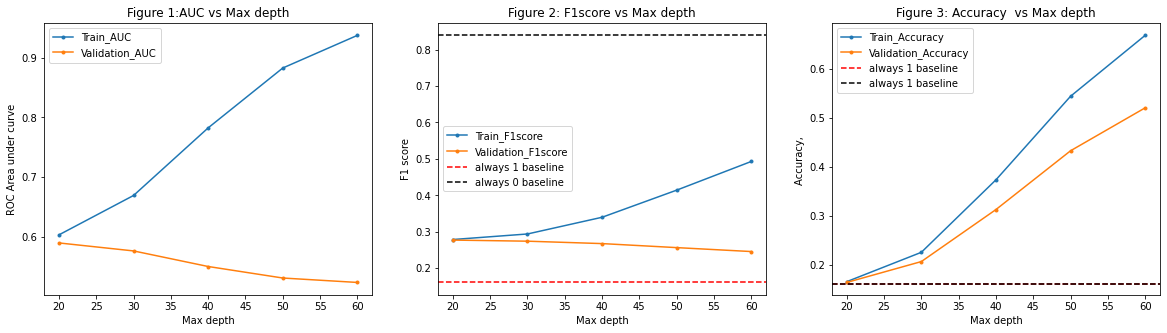

In [74]:
plt.subplots(1,3,figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(dtree_metrics['train_AUC'],'.-',label='Train_AUC')
plt.plot(dtree_metrics['valid_AUC'],'.-',label='Validation_AUC')
plt.title("Figure 1:AUC vs Max depth")
plt.xlabel("Max depth")
plt.ylabel("ROC Area under curve")
plt.legend()

plt.subplot(1,3,2)
plt.plot(dtree_metrics['train_f1'],'.-',label='Train_F1score')
plt.plot(dtree_metrics['valid_f1'],'.-',label='Validation_F1score')
# getting accuracy for baseline model that always predicts 1 no matter what.
baseline1_f1 = accuracy_score(y_test, [1]*y_test.shape[0])
# getting accuracy for baseline model that always predicts 0 no matter what.
baseline0_f1 = accuracy_score(y_test, [0]*y_test.shape[0])
plt.axhline(baseline1_f1,color = 'red',linestyle = '--',label="always 1 baseline")
plt.axhline(baseline0_f1,color = 'black',linestyle = '--',label="always 0 baseline")
plt.xlabel("Max depth")
plt.ylabel("F1 score")
plt.title("Figure 2: F1score vs Max depth")
plt.legend()

plt.subplot(1,3,3)
plt.plot(dtree_metrics['train_accuracy'],'.-',label='Train_Accuracy')
plt.plot(dtree_metrics['valid_accuracy'],'.-',label='Validation_Accuracy')
# getting accuracy for baseline model that always predicts 1 no matter what.
baseline1_acc = accuracy_score(y_test, [1]*y_test.shape[0])
# getting accuracy for baseline model that always predicts 0 no matter what.
baseline0_acc = accuracy_score(y_test, [0]*y_test.shape[0])
plt.axhline(baseline1_acc,color = 'red',linestyle = '--',label="always 1 baseline")
plt.axhline(baseline1_acc,color = 'black',linestyle = '--',label="always 1 baseline")
plt.xlabel("Max depth")
plt.ylabel("Accuracy, ")
plt.title("Figure 3: Accuracy  vs Max depth")
plt.legend()

plt.show()

Max_depth of 10 and 12 is chosen for further analysis:
confusion matrix and precision recall curve

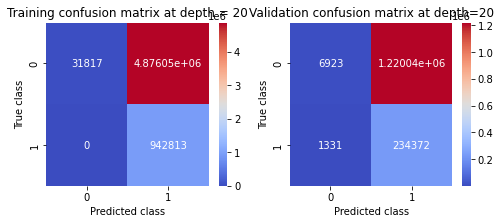

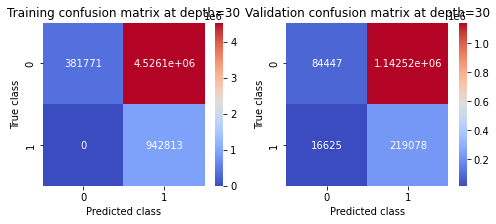

In [75]:
plt.subplots(2,2,figsize=(8,3))
d1 = 20
d2 = 30

plt.subplot(1,2,1)
sns.heatmap(train_cm[d1],cmap="coolwarm",annot=True,fmt='g')
plt.title(f"Training confusion matrix at depth = {d1}")
plt.xlabel("Predicted class")
plt.ylabel("True class")

plt.subplot(1,2,2)
sns.heatmap(valid_cm[d1],cmap="coolwarm",annot=True,fmt='g')
plt.title(f"Validation confusion matrix at depth={d1}")
plt.xlabel("Predicted class")
plt.ylabel("True class")

plt.show()


plt.subplots(2,2,figsize=(8,3))

plt.subplot(1,2,1)
sns.heatmap(train_cm[d2],cmap="coolwarm",annot=True,fmt='g')
plt.title(f"Training confusion matrix at depth={d2}")
plt.xlabel("Predicted class")
plt.ylabel("True class")

plt.subplot(1,2,2)
sns.heatmap(valid_cm[d2],cmap="coolwarm",annot=True,fmt='g')
plt.title(f"Validation confusion matrix at depth={d2}")
plt.xlabel("Predicted class")
plt.ylabel("True class")

plt.show()

Precision and recall for both decision trees are low. There are a lot of false negatives.

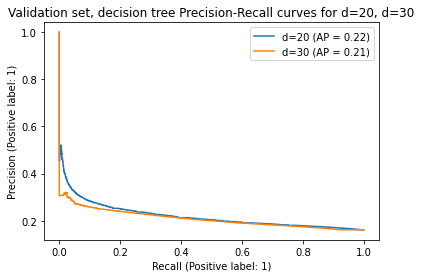

In [76]:
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

precision3, recall3, thresholds3 = precision_recall_curve(y_test, valid_proba1[d1])
precision5, recall5, thresholds5 = precision_recall_curve(y_test, valid_proba1[d2])

# create subplots
plt.figure()
ax = plt.gca()
#plt.step(recall3,precision3,where='mid',label="d=3")
#plt.step(recall5,precision5,where = 'mid',label="d=5")

# precision_recall_curve(y_valid,valid_proba1[21],ax=ax,name="k=21")
PrecisionRecallDisplay.from_predictions(y_test,valid_proba1[d1],ax=ax,name=f"d={d1}")
PrecisionRecallDisplay.from_predictions(y_test,valid_proba1[d2],ax=ax,name=f"d={d2}")
plt.legend()
plt.title(f"Validation set, decision tree Precision-Recall curves for d={d1}, d={d2}")
plt.show()

Trying downsampling to a balanced dataset. 

In [12]:
y_train.value_counts()

0    4907870
1     942813
Name: p_forgot_bin, dtype: int64

We will reduce the counts of 0s to be the same as the counts of 1.

In [30]:





# importing resampling
from sklearn.utils import resample

def downsample(X_train_unscaled,y_train,frac_ones,random_state):
  """
  Downsample the training Xy concatenated data to the fraction of ones wanted. 
  
  Inputs:
  X_train_unscaled : the dataframe with features
  y_train : the series with target variable corresponding to X_train_unscaled containing 0 adn 1 only.
  frac_ones: the fraction of y=1 in the dataset
  random_state: the random seed number to use when sampling from the zeros.
  Outputs:
  x_train_downsampled, y_train_downsampled

  
  Example: if frac_ones = 0.5, then we will downsample the zeros so that it is half the dataset.
  """
  # getting the number of ones and zeros in target variable
  num_zeros = y_train[y_train==0].shape[0]
  num_ones = y_train[y_train==1].shape[0]

  # what should be our final counts of zeros to achieve the frac_ones in arguments.
  final_numzeros = np.around(num_ones*(1-frac_ones)/frac_ones,0).astype(int)

  # joining X and y training before downsampling
  Xy = pd.concat([X_train_unscaled,y_train],axis=1)

  # filtering out the rows with y==0
  Xyzeros = Xy[y_train==0]

  #fraction to sample from zeros data
  fractionzeros = final_numzeros/num_zeros

  #sampling from Xyzeros using the random seed number:
  final_Xyzeros = Xyzeros.sample(n = final_numzeros,random_state=random_state)

  # concatenating with Xyones
  Xyones = Xy[y_train==1]
  final_Xy = pd.concat([Xyones,final_Xyzeros],axis=0)

  #splitting into X and y
  y_train_downsampled = final_Xy[y_train.name]
  X_train_downsampled = final_Xy.drop(y_train.name,axis=1)

  return X_train_downsampled,y_train_downsampled




# grateful for the fact that i am here now.
# grateful for my marks being good
# grateful for Vai's support
# grateful for beautiful weather
# grateful for money to buy whatever i need.
# grateful for all the people who have been so prompt in replying on LinkedIn
# grateful for mental health resources and medication
# grateful for space from my parents.
# grateful for 


In [31]:
X_train_downsampled,y_train_downsampled = downsample(X_train_unscaled,y_train,frac_ones=0.5,random_state=1)

In [32]:
X_train_unscaled.shape,X_train_downsampled.shape

((5850683, 11), (1885626, 11))

SVM with different solvers (linear and radial) - try downsampling, mostly down and a little up and so on.

In [ ]:
#from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pca import PCA
from sklearn.svm import SVC
pipe1 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train_unscaled, y_train)


Break and try PCA. 
then try SGD classifier.